In [29]:
import pandas as pd
# Load the dataset
df = pd.read_csv('C:/Users/User/Downloads/insurance (1).csv')
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Summary statistics
print("\nSummary statistics of numerical features:")
print(df.describe())

# Information about the dataset
print("\nInformation about the dataset:")
print(df.info())


First few rows of the dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Summary statistics of numerical features:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

Informatio

<Figure size 1200x800 with 0 Axes>

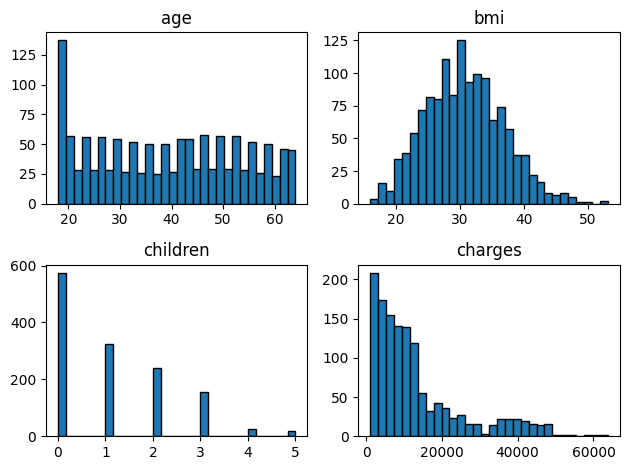

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms of numerical features
plt.figure(figsize=(12, 8))
df.hist(bins=30, edgecolor='black', grid=False)
plt.tight_layout()
plt.show()


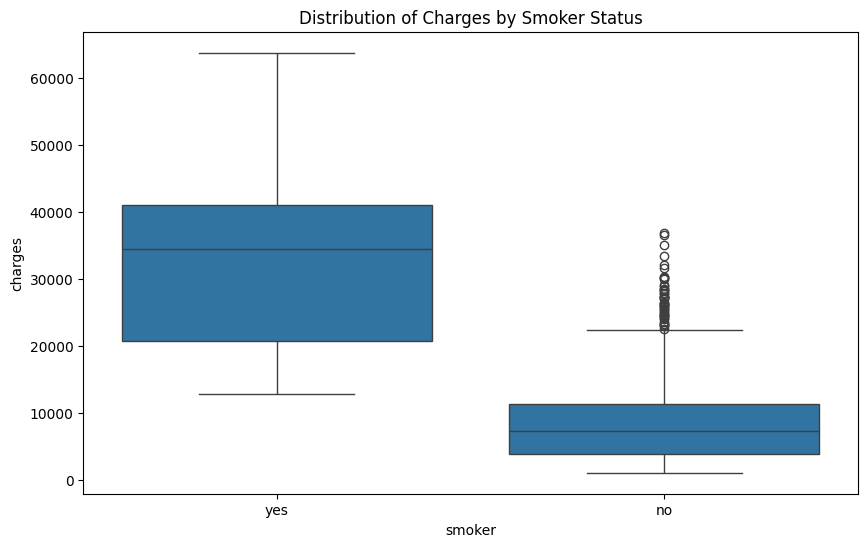

In [32]:
# Boxplot for 'charges' distribution by 'smoker' status
plt.figure(figsize=(10, 6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Distribution of Charges by Smoker Status')
plt.show()

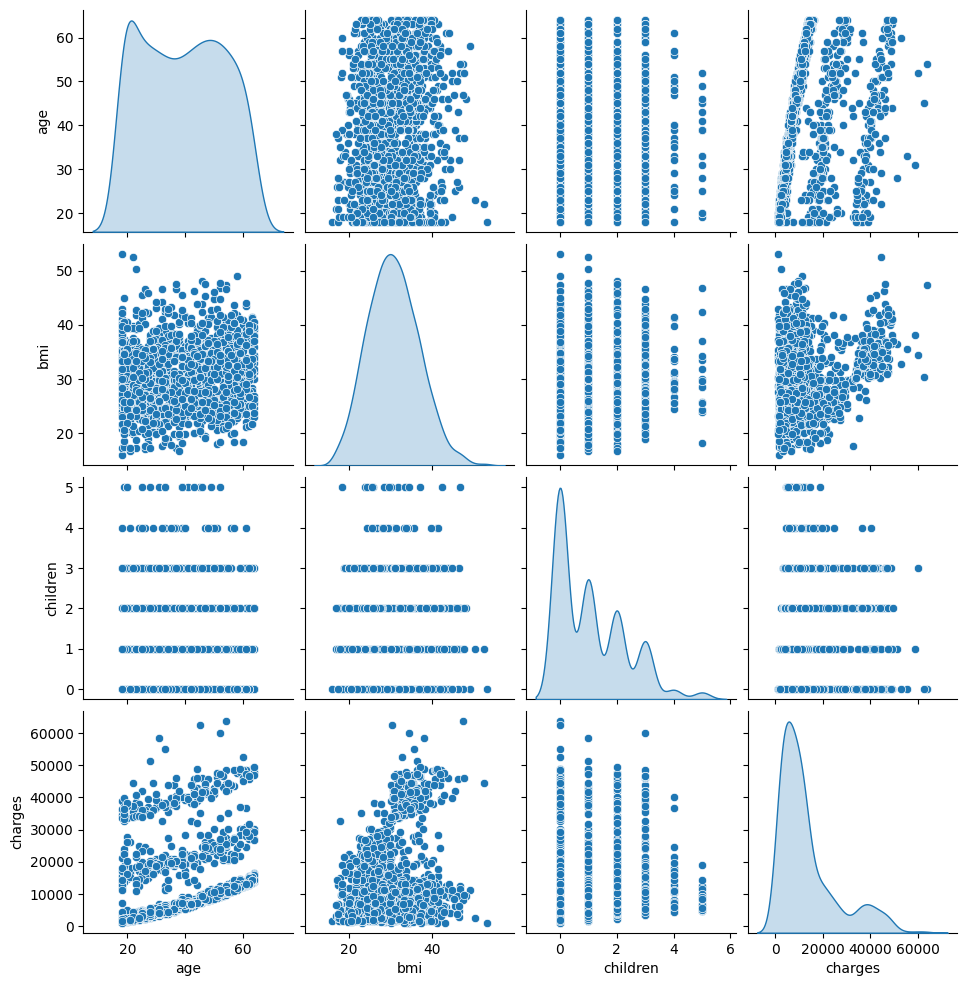

In [33]:
# Pairplot for selected features
sns.pairplot(df[['age', 'bmi', 'children', 'charges', 'smoker']], diag_kind='kde')
plt.show()



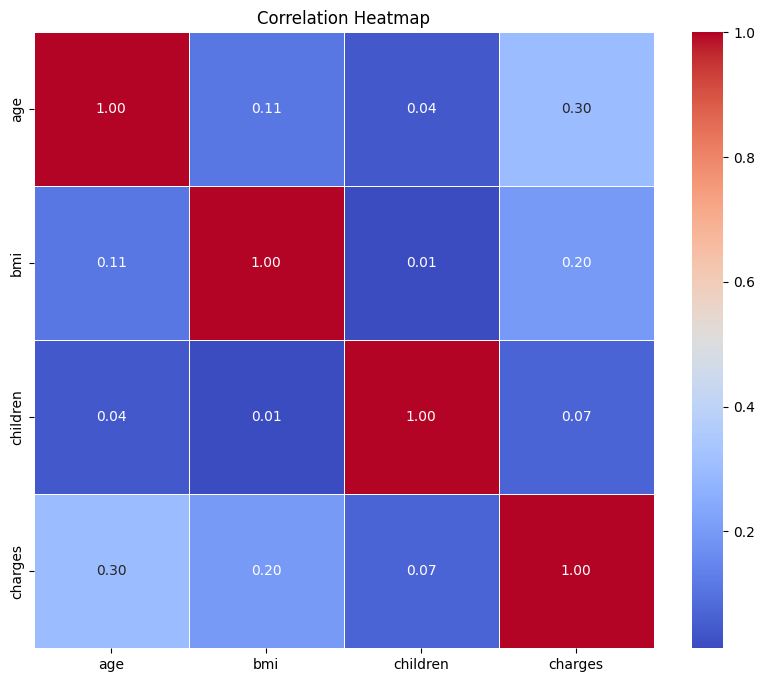

In [34]:

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[['age', 'bmi', 'children', 'charges']].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

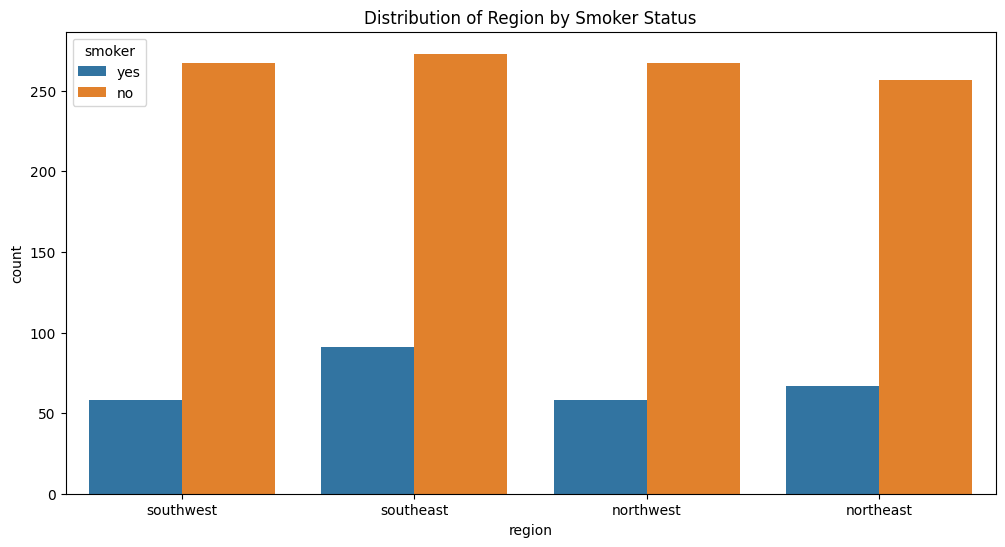

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(x='region', data=df, hue='smoker')
plt.title('Distribution of Region by Smoker Status')
plt.show()


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

# Load the dataset
df = pd.read_csv('C:/Users/User/Downloads/insurance (1).csv')

# Preprocess the dataset
df['sex'] = df['sex'].str.lower().map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].str.lower().map({'yes': 1, 'no': 0})

# Check for unique regions and create dummy variables
print("Unique regions before creating dummies:", df['region'].unique())
df = pd.get_dummies(df, columns=['region'])
print("Columns after creating dummies:", df.columns)

df['sex'].fillna(df['sex'].mode()[0], inplace=True)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
df['children'].fillna(df['children'].mean(), inplace=True)
df['smoker'].fillna(df['smoker'].mode()[0], inplace=True)
df['charges'].fillna(df['charges'].mean(), inplace=True)

df['high_risk_flag'] = np.where((df['bmi'] > 30) & (df['smoker'] == 1), 1, 0)
df['fraud_flag'] = np.random.randint(0, 2, df.shape[0])

df.dropna(inplace=True)

# Define features and target for fraud detection
features = ['age', 'sex', 'bmi', 'children', 'smoker'] + [col for col in df.columns if 'region_' in col]
fraud_target = 'fraud_flag'

# Split the data for fraud detection
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(df[features], df[fraud_target], test_size=0.2, random_state=42)

# Define and train the stacking classifier for fraud detection
fraud_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gbr', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(kernel='linear', probability=True)),
        ('xgb', xgb.XGBClassifier(random_state=42))
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

fraud_model.fit(X_train_fraud, y_train_fraud)
fraud_predictions = fraud_model.predict(X_test_fraud)

# Function to print classification metrics
def print_classification_metrics(y_true, y_pred, title):
    print(f"=== {title} ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

# Print classification metrics for fraud detection
print_classification_metrics(y_test_fraud, fraud_predictions, "Fraud Detection")

# Save the fraud detection model
with open('fraud_model.pkl', 'wb') as f:
    pickle.dump(fraud_model, f)

# Make predictions for a sample data
# Ensure the sample_data has the same columns as features
sample_data = pd.DataFrame([[25, 1, 22.5, 0, 0, 0, 1, 0, 0]], columns=features)
predicted_fraud = fraud_model.predict(sample_data)
print(f"Predicted Fraud Flag: {predicted_fraud[0]}")

# Print completion message
print("Fraud model training, saving, and prediction complete.")


Unique regions before creating dummies: ['southwest' 'southeast' 'northwest' 'northeast']
Columns after creating dummies: Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')
=== Fraud Detection ===
Accuracy: 0.5000
Confusion Matrix:
[[79 50]
 [84 55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.61      0.54       129
           1       0.52      0.40      0.45       139

    accuracy                           0.50       268
   macro avg       0.50      0.50      0.50       268
weighted avg       0.50      0.50      0.49       268

Predicted Fraud Flag: 0
Fraud model training, saving, and prediction complete.


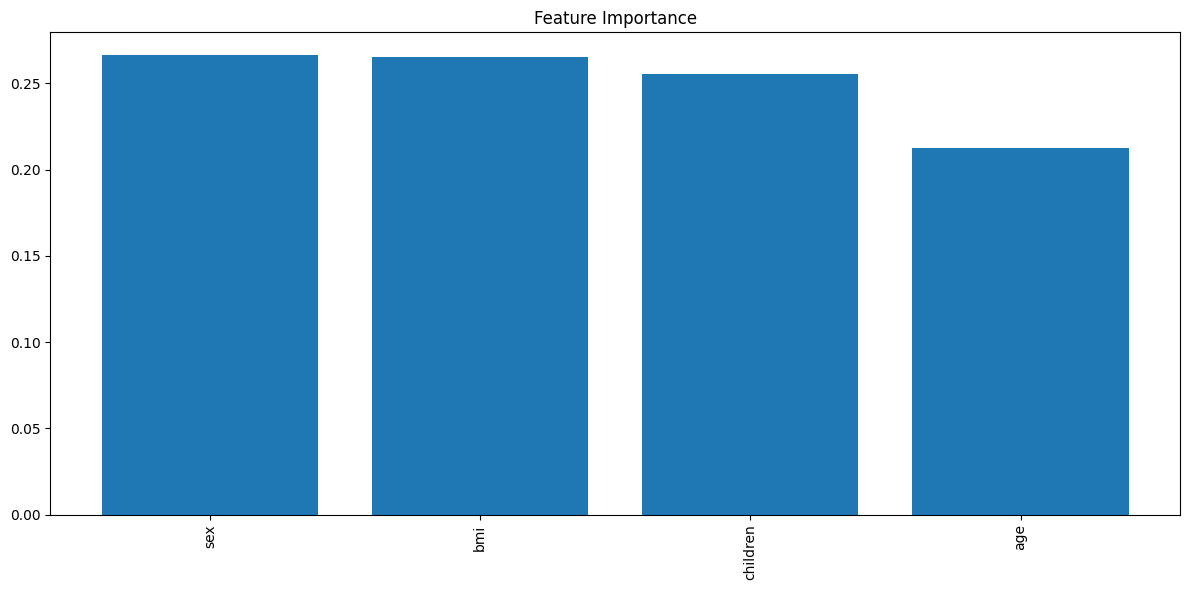

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

# Feature Importance
final_model = fraud_model.final_estimator_
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feature_names = features
    sorted_indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title('Feature Importance')
    plt.bar(range(len(importances)), importances[sorted_indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()

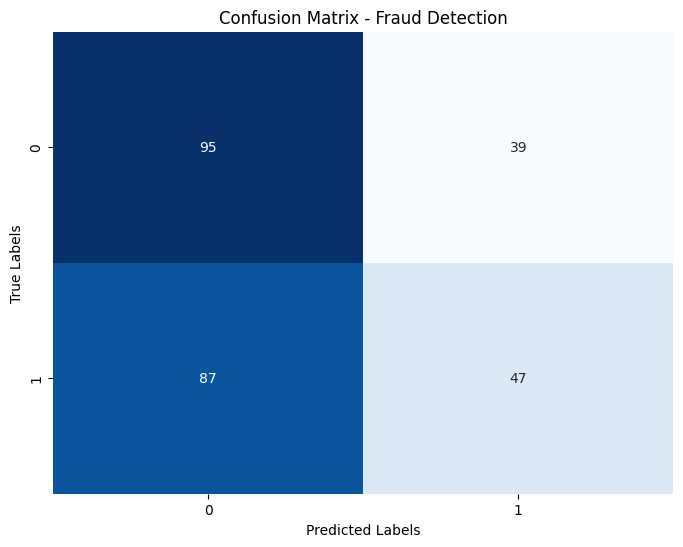

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_fraud, fraud_predictions), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fraud Detection')
plt.show()


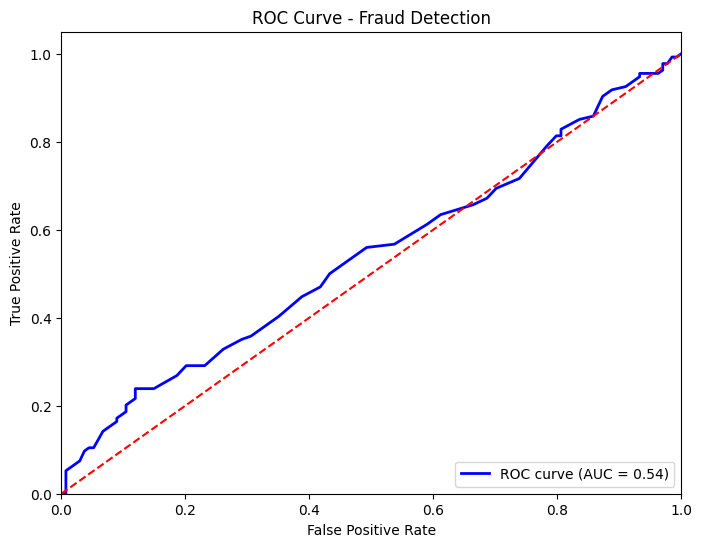

In [21]:

from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve and AUC
y_scores = fraud_model.predict_proba(X_test_fraud)[:, 1]  # Probability scores for fraud class
fpr, tpr, thresholds = roc_curve(y_test_fraud, y_scores)
auc = roc_auc_score(y_test_fraud, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fraud Detection')
plt.legend(loc='lower right')
plt.show()


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

# Load the dataset
df = pd.read_csv('C:/Users/User/Downloads/insurance (1).csv')

# Preprocess the dataset
df['sex'] = df['sex'].str.lower().map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].str.lower().map({'yes': 1, 'no': 0})
df = pd.get_dummies(df, columns=['region'])

df['sex'].fillna(df['sex'].mode()[0], inplace=True)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
df['children'].fillna(df['children'].mean(), inplace=True)
df['smoker'].fillna(df['smoker'].mode()[0], inplace=True)
df['charges'].fillna(df['charges'].mean(), inplace=True)

df['high_risk_flag'] = np.where((df['bmi'] > 30) & (df['smoker'] == 1), 1, 0)
df.dropna(inplace=True)

features = ['age', 'sex', 'bmi', 'children', 'smoker'] + [col for col in df.columns if 'region_' in col]
high_risk_target = 'high_risk_flag'

X_train_high_risk, X_test_high_risk, y_train_high_risk, y_test_high_risk = train_test_split(df[features], df[high_risk_target], test_size=0.2, random_state=42)

high_risk_model = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gbr', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(kernel='linear', probability=True)),
        ('xgb', xgb.XGBClassifier(random_state=42))
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

high_risk_model.fit(X_train_high_risk, y_train_high_risk)
high_risk_predictions_proba = high_risk_model.predict_proba(X_test_high_risk)[:, 1]  # Predict probabilities for class 1 (high risk)

# Define thresholds for categorization
low_threshold = 0.3
high_threshold = 0.7

# Categorize predictions based on thresholds
high_risk_predictions = np.where(high_risk_predictions_proba < low_threshold, 'Low', 
                        np.where(high_risk_predictions_proba < high_threshold, 'Medium', 'High'))

# Save the high-risk model as a pickle file
with open('high_risk_model.pkl', 'wb') as f:
    pickle.dump(high_risk_model, f)

# Predict for sample data
sample_data = pd.DataFrame([[25, 1, 22.5, 0, 0, 0, 1, 0, 0]], columns=features)
predicted_high_risk_proba = high_risk_model.predict_proba(sample_data)[:, 1]
predicted_high_risk_category = np.where(predicted_high_risk_proba < low_threshold, 'Low', 
                                        np.where(predicted_high_risk_proba < high_threshold, 'Medium', 'High'))

print(f"Predicted High-Risk Probability: {predicted_high_risk_proba[0]:.2f}")
print(f"Predicted High-Risk Category: {predicted_high_risk_category[0]}")

def print_classification_metrics(y_true, y_pred, model_name):
    # Map categorical predictions to numerical labels
    label_map = {"Low": 0, "Medium": 1, "High": 2}
    y_pred_numeric = np.array([label_map[label] for label in y_pred])

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred_numeric):.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred_numeric))
    print("Classification Report:")
    print(classification_report(y_true, y_pred_numeric))
    print("\n")

# Call the function with categorical predictions
print_classification_metrics(y_test_high_risk, high_risk_predictions, "High-Risk Customer Identification")


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Predicted High-Risk Probability: 0.00
Predicted High-Risk Category: Low
Model: High-Risk Customer Identification
Accuracy: 0.89
Confusion Matrix:
[[238   1   0]
 [  0   0  29]
 [  0   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00         0

    accuracy                           0.89       268
   macro avg       0.33      0.33      0.33       268
weighted avg       0.89      0.89      0.89       268





C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: Undefin

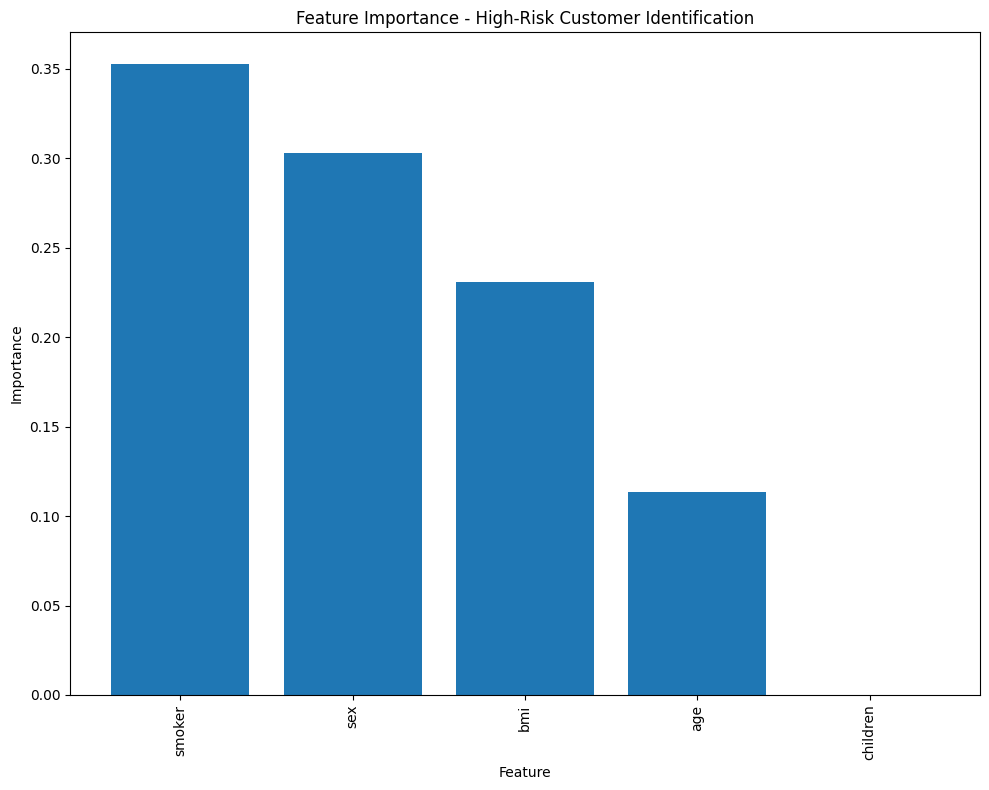

In [42]:
if hasattr(high_risk_model.final_estimator_, 'feature_importances_'):
    importances = high_risk_model.final_estimator_.feature_importances_
    feature_names = X_train_high_risk.columns
    sorted_indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 8))
    plt.bar(range(len(importances)), importances[sorted_indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance - High-Risk Customer Identification')
    plt.tight_layout()
    plt.show()


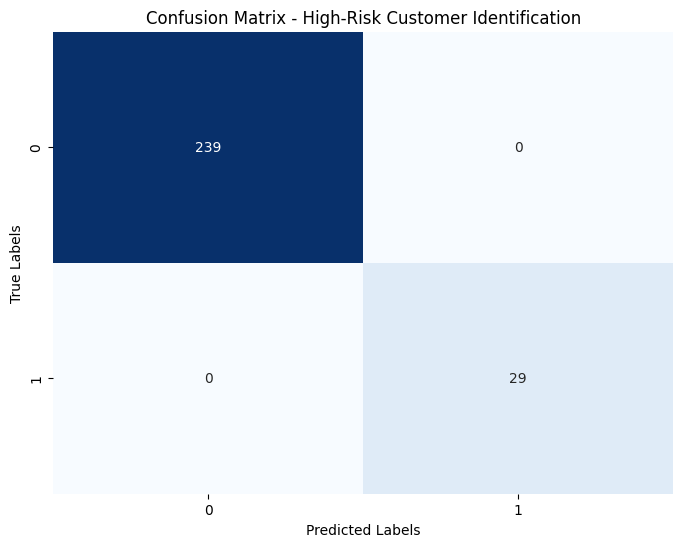

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate predictions
high_risk_predictions = high_risk_model.predict(X_test_high_risk)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_high_risk, high_risk_predictions), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - High-Risk Customer Identification')
plt.show()


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import pickle

df = pd.read_csv('C:/Users/User/Downloads/insurance (1).csv')

df['sex'] = df['sex'].str.lower().map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].str.lower().map({'yes': 1, 'no': 0})
df = pd.get_dummies(df, columns=['region'])

df['sex'].fillna(df['sex'].mode()[0], inplace=True)
df['bmi'].fillna(df['bmi'].mean(), inplace=True)
df['children'].fillna(df['children'].mean(), inplace=True)
df['smoker'].fillna(df['smoker'].mode()[0], inplace=True)
df['charges'].fillna(df['charges'].mean(), inplace=True)


df.dropna(inplace=True)

features = ['age', 'sex', 'bmi', 'children', 'smoker'] + [col for col in df.columns if 'region_' in col]
premium_target = 'charges'

X_train_premium, X_test_premium, y_train_premium, y_test_premium = train_test_split(df[features], df[premium_target], test_size=0.2, random_state=42)

premium_model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42)),
        ('svr', SVR(kernel='linear')),
        ('xgb', xgb.XGBRegressor(random_state=42))
    ],
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42)
)

premium_model.fit(X_train_premium, y_train_premium)


with open('premium_model.pkl', 'wb') as f:
    pickle.dump(premium_model, f)

sample_data = pd.DataFrame([[25, 1, 22.5, 0, 0, 0, 1, 0, 0]], columns=features)
predicted_premium = premium_model.predict(sample_data)
print(f"Predicted Premium: {predicted_premium[0]:.2f}")


print("Premium model training, saving, and prediction complete.")


Predicted Premium: 3287.07
Premium model training, saving, and prediction complete.


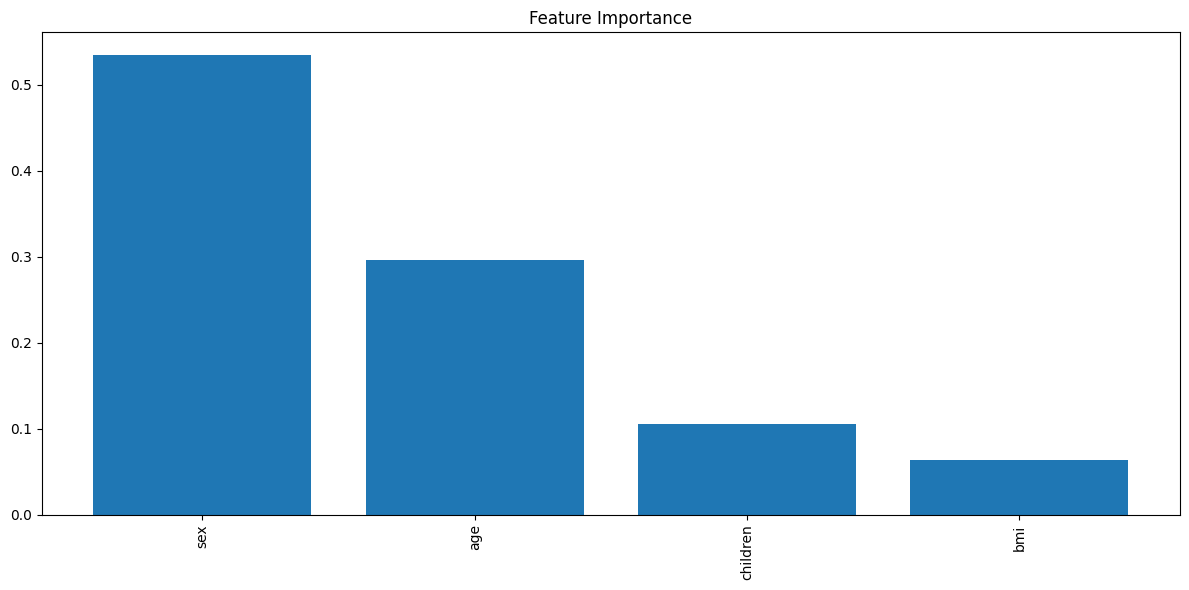

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

# Feature Importance
final_model = premium_model.final_estimator_
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feature_names = features
    sorted_indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title('Feature Importance')
    plt.bar(range(len(importances)), importances[sorted_indices], align='center')
    plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()






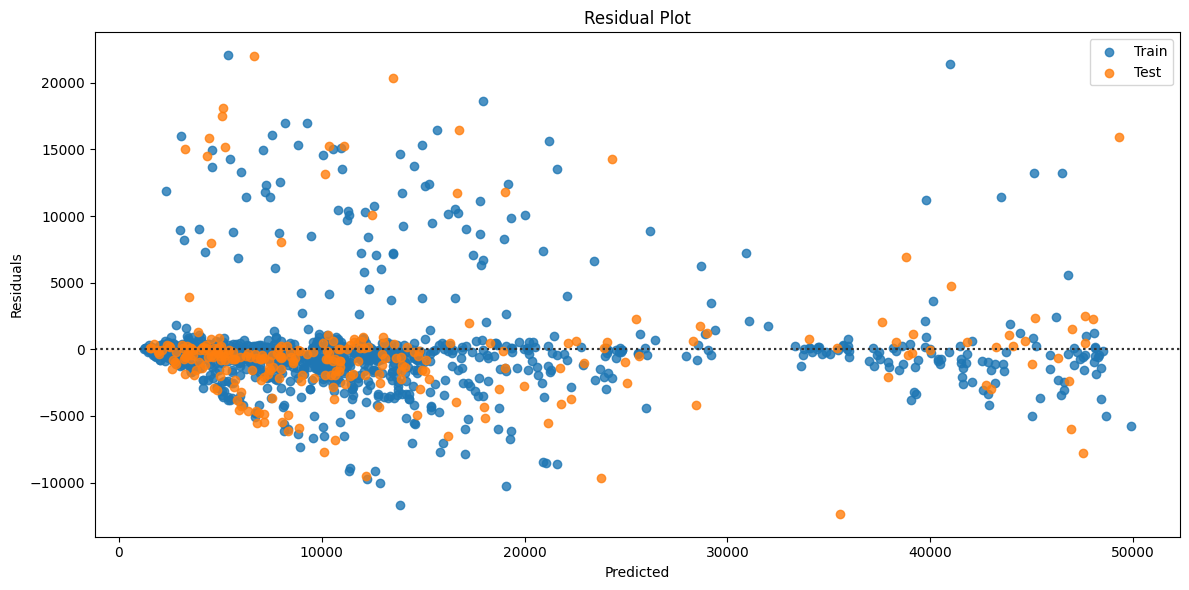

In [11]:
# Residual Plot
y_train_pred = premium_model.predict(X_train_premium)
y_test_pred = premium_model.predict(X_test_premium)

plt.figure(figsize=(12, 6))
plt.title('Residual Plot')
sns.residplot(x=y_train_pred, y=y_train_premium - y_train_pred, label='Train')
sns.residplot(x=y_test_pred, y=y_test_premium - y_test_pred, label='Test')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.legend()
plt.tight_layout()
plt.show()

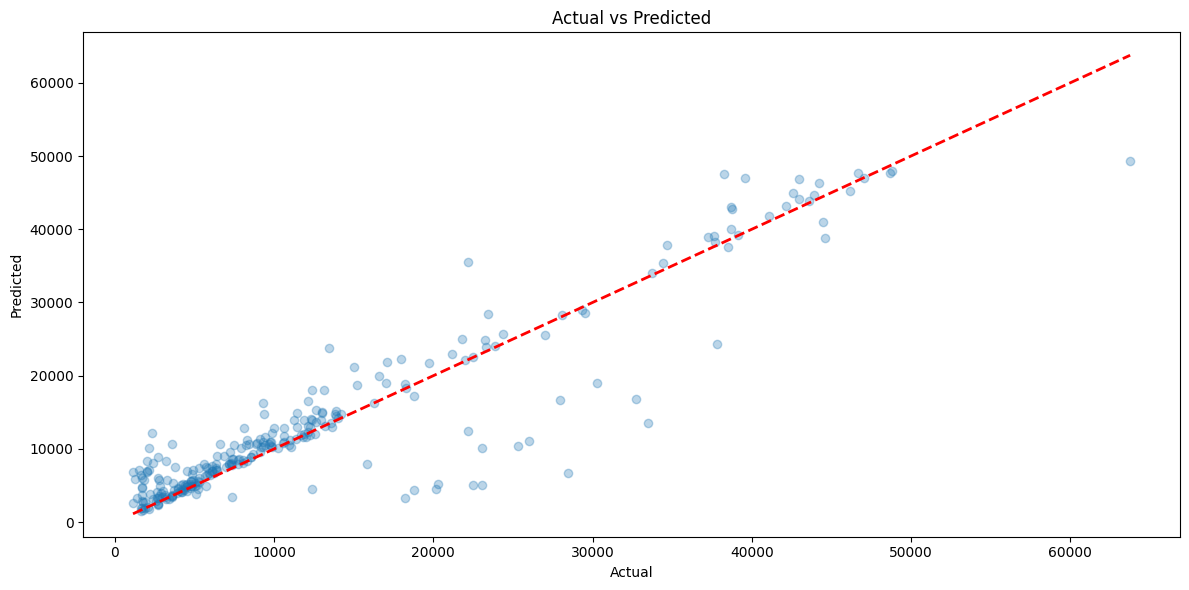

In [12]:
# Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.title('Actual vs Predicted')
plt.scatter(y_test_premium, y_test_pred, alpha=0.3)
plt.plot([y_test_premium.min(), y_test_premium.max()], [y_test_premium.min(), y_test_premium.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()



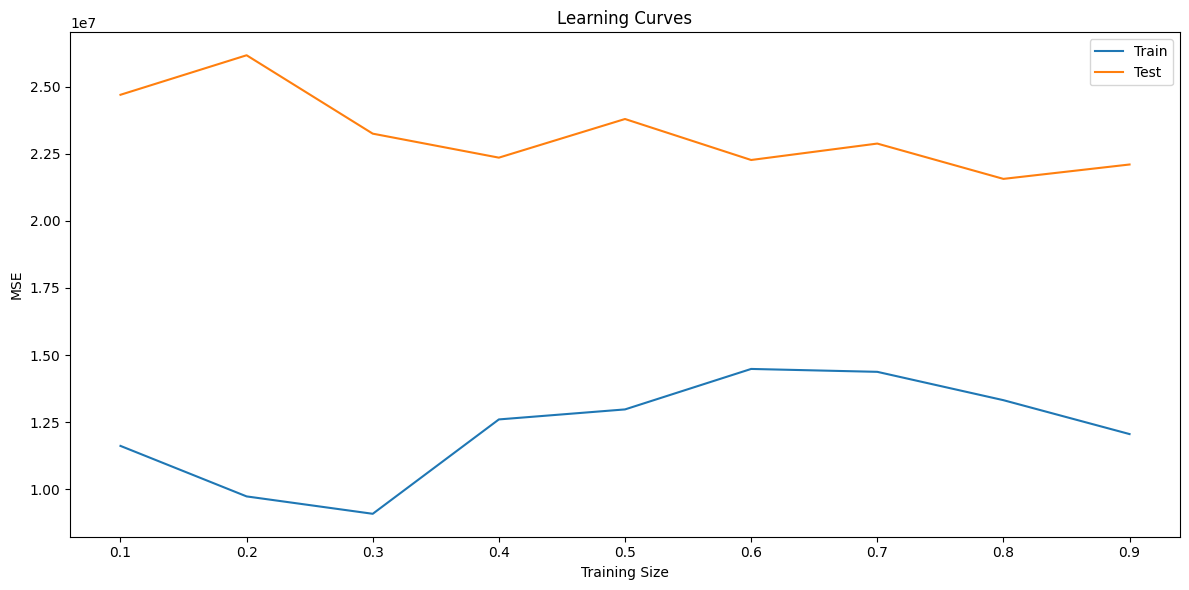

In [13]:
# Learning Curves
train_sizes = np.linspace(0.1, 0.9, 9)  # Avoid using 1.0
train_scores, test_scores = [], []

for train_size in train_sizes:
    X_train_part, _, y_train_part, _ = train_test_split(X_train_premium, y_train_premium, train_size=train_size, random_state=42)
    premium_model.fit(X_train_part, y_train_part)
    train_scores.append(mean_squared_error(y_train_part, premium_model.predict(X_train_part)))
    test_scores.append(mean_squared_error(y_test_premium, premium_model.predict(X_test_premium)))

plt.figure(figsize=(12, 6))
plt.title('Learning Curves')
plt.plot(train_sizes, train_scores, label='Train')
plt.plot(train_sizes, test_scores, label='Test')
plt.xlabel('Training Size')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()